In [153]:
import numpy as np
import scipy as sp
import glob

from IPython.display import clear_output

from matplotlib import pyplot as plt

def to_xy(az, el, c_az, c_el):
    ground_X, ground_Y, ground_Z = np.sin(az-c_az)*np.cos(el), np.cos(az-c_az)*np.cos(el), np.sin(el)
    return np.arcsin(ground_X), np.arcsin(-np.real((ground_Y+1j*ground_Z)*np.exp(1j*(np.pi/2-c_el))))

def from_xy(dx, dy, c_az, c_el):
    ground_X, Y, Z = np.sin(dx+1e-16), -np.sin(dy+1e-16), np.cos(np.sqrt(dx**2+dy**2))
    gyz = (Y+1j*Z)*np.exp(-1j*(np.pi/2-c_el))
    ground_Y, ground_Z = np.real(gyz), np.imag(gyz)
    return (np.angle(ground_Y+1j*ground_X) + c_az) % (2*np.pi), np.arcsin(ground_Z)

def get_MARA(z): # minimal-area rotation angle 

    H  = sp.spatial.ConvexHull(points=np.vstack([np.real(z).ravel(),np.imag(z).ravel()]).T)
    HZ = z.ravel()[H.vertices]

    HE = np.imag(HZ).max() - np.imag(HZ).min(); HO = 0
    #for z1,z2 in zip(HZ,np.roll(HZ,1)):
    for RHO in np.linspace(0,np.pi,1024+1)[1:]:

        #RHO = np.angle(z2-z1)
        RHZ = HZ * np.exp(1j*RHO)
        
        #im_width = (np.imag(RHZ).max() - np.imag(RHZ).min())
        #re_width = (np.real(RHZ).max() - np.real(RHZ).min())
        
        im_width = np.abs(np.subtract(*np.percentile(np.real(RHZ), q=[10, 90])))
        re_width = np.abs(np.subtract(*np.percentile(np.imag(RHZ), q=[10, 90])))
        
        RHE = im_width #* re_width

        if RHE < HE and re_width > im_width: 
            HE = RHE; HO = RHO
            
    return HO


In [154]:
res = 0.01

mlat_bins = np.arange(-90, 90 + 1e-6, res)
mlon_bins = np.arange(-180, 180 + 1e-6, res)

mlat = 0.5 * (mlat_bins[1:] + mlat_bins[:-1])
mlon = 0.5 * (mlon_bins[1:] + mlon_bins[:-1])

MLAT, MLON = np.meshgrid(mlat, mlon, indexing='ij')
MLAT.shape

(18000, 36000)

In [155]:
filepaths = glob.glob('/users/thomas/desktop/datasets/heightmaps/*')
filepaths

['/users/thomas/desktop/datasets/heightmaps/gebco_2022_n0.0_s-90.0_w-60.0_e60.0.tif',
 '/users/thomas/desktop/datasets/heightmaps/gebco_2022_n0.0_s-90.0_w60.0_e180.0.tif',
 '/users/thomas/desktop/datasets/heightmaps/gebco_2022_n90.0_s0.0_w-180.0_e-60.0.tif',
 '/users/thomas/desktop/datasets/heightmaps/gebco_2022_n90.0_s0.0_w-60.0_e60.0.tif',
 '/users/thomas/desktop/datasets/heightmaps/gebco_2022_n0.0_s-90.0_w-180.0_e-60.0.tif',
 '/users/thomas/desktop/datasets/heightmaps/gebco_2022_n90.0_s0.0_w60.0_e180.0.tif']

In [ ]:
import re
import PIL
from PIL import Image


from scipy import stats

PIL.Image.MAX_IMAGE_PIXELS = 933120000

BS = np.zeros(MLAT.shape)
BN = np.zeros(MLAT.shape)

for fp in filepaths:
    
    print(fp)

    lat_max, lat_min, lon_min, lon_max = [float(x) for x in re.findall(r'.+2022_n(.+)_s(.+)_w(.+)_e(.+).tif', fp)[0]]

    %time H = np.array(Image.open(fp))[::2,::2][::-1]

    lat_bins = np.linspace(lat_min, lat_max, H.shape[0] + 1)
    lon_bins = np.linspace(lon_min, lon_max, H.shape[1] + 1)

    lat = 0.5 * (lat_bins[1:] + lat_bins[:-1])
    lon = 0.5 * (lon_bins[1:] + lon_bins[:-1])

    LAT, LON = np.meshgrid(lat, lon, indexing='ij')
    
    %time _BS = sp.stats.binned_statistic_2d(LAT.ravel(), LON.ravel(), H.ravel(), bins=(mlat_bins, mlon_bins), statistic='sum')[0]
    %time _BN = sp.stats.binned_statistic_2d(LAT.ravel(), LON.ravel(), 0, bins=(mlat_bins, mlon_bins), statistic='count')[0]
    #%time _BH = sp.stats.binned_statistic_2d(LAT.ravel(), LON.ravel(), H.ravel(), bins=(mlat_bins, mlon_bins), statistic='mean')[0]
    
    BS += _BS
    BN += _BN

    del H
    

/users/thomas/desktop/datasets/heightmaps/gebco_2022_n0.0_s-90.0_w-60.0_e60.0.tif
CPU times: user 4.09 s, sys: 4.74 s, total: 8.82 s
Wall time: 9.77 s


In [1]:
H

NameError: name 'H' is not defined

In [ ]:
MH = (BS / BN).astype(int)

np.save('/users/thomas/desktop/datasets/heightmaps/global_heightmap_0.01deg.npy', MH)

In [148]:
h_contour = 1e-1

from skimage import measure
contours = measure.find_contours(MH.T, 0)

bounding_areas = [-np.product(contour.ptp(axis=0)) for contour in contours]
contours = [contours[i] for i in np.argsort(bounding_areas)[:200]]

In [149]:
lon0, lat0 = -73.07, 40.95

r = 2

lon_lims = (lon0-r, lon0+r)
lat_lims = (lat0-r, lat0+r)

#lon_lims = (-80, -70)
#lat_lims = (+35, +45)

#lon_lims = (-180, 180)
#lat_lims = (-90, +90)


mi = (mlat > lat_lims[0]) & (mlat < lat_lims[1])
mj = (mlon > lon_lims[0]) & (mlon < lon_lims[1])

MH.shape, mi.shape, mj.shape

((9000, 18000), (9000,), (18000,))

(9000, 18000)

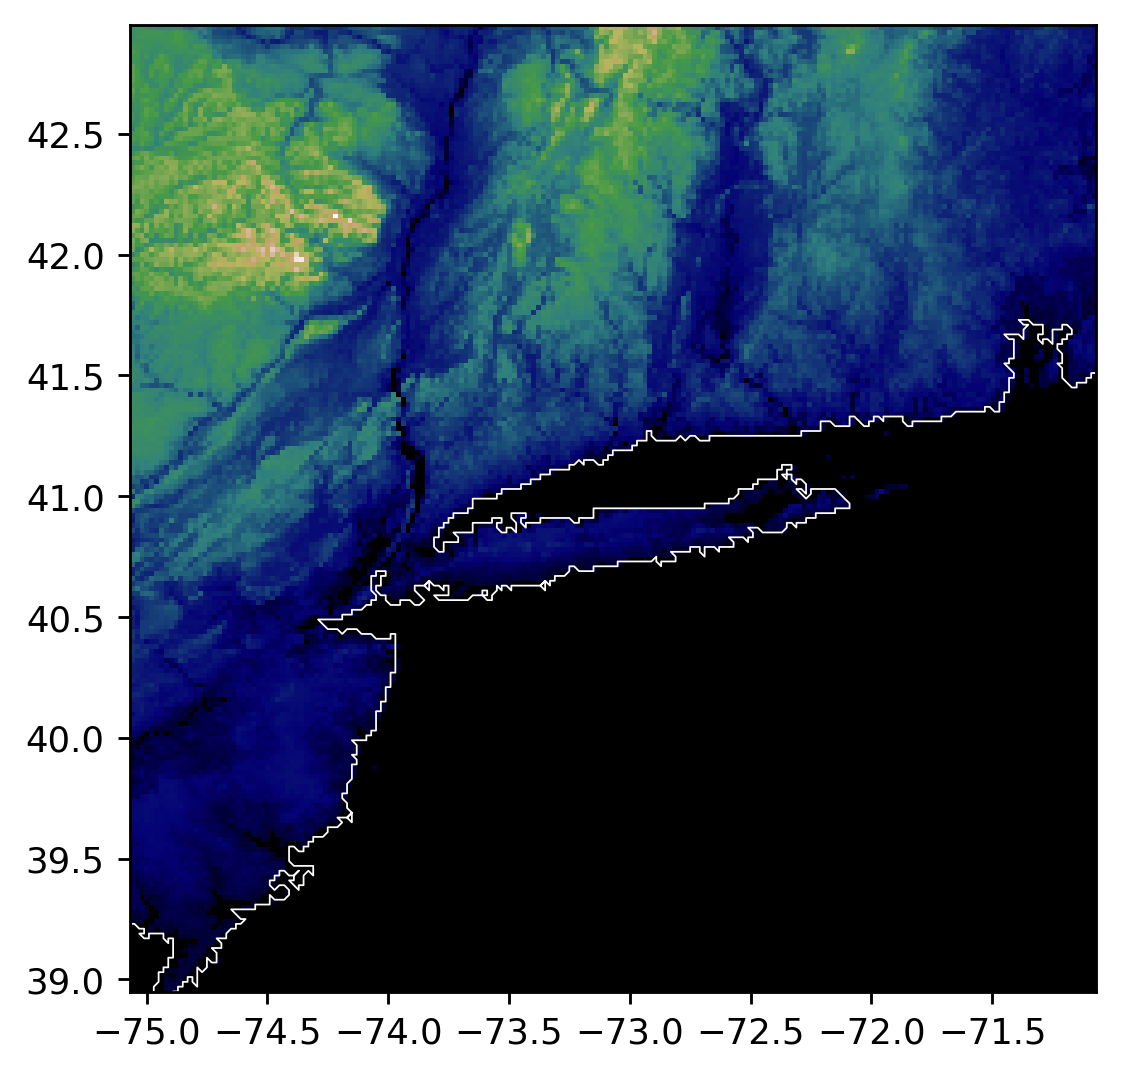

In [150]:
fig, ax = plt.subplots(1,1,figsize=(8,5), dpi=256)

ax.imshow(MH[mi][:,mj][::-1], cmap='gist_earth', extent=[*lon_lims, *lat_lims], vmin=0)

for contour in contours[0:70]:
    
    plt.plot(mlon[contour[:,0].astype(int)], mlat[contour[:,1].astype(int)], lw=5e-1, c='w')

plt.xlim(*lon_lims)
plt.ylim(*lat_lims)
MH.shape

In [84]:
def get_lwr(z):
    
    mara = get_MARA(z_contour)

    z_trans = z_contour * np.exp(1j * mara)
    dx_trans, dy_trans = np.real(z_trans), np.imag(z_trans)
    
    l0, l1 = np.percentile(dy_trans, q=[10, 90])
    h0, h1 = np.percentile(dx_trans, q=[10, 90])
    
    return (l1-l0) / (h1-h0)

In [85]:
lwrs = []

for ic in range(10):
    
    contour = contours[ic]
    
    c_lon, c_lat = np.radians(lon[contour[:,0].astype(int)]), np.radians(lat[contour[:,1].astype(int)])
    dx, dy       = to_xy(c_lon, c_lat, c_lon.mean(), c_lat.mean())
    z_contour    = dx + 1j * dy
    
    lwrs.append(get_lwr(z_contour))
    
    print(ic); clear_output(wait=True)

9


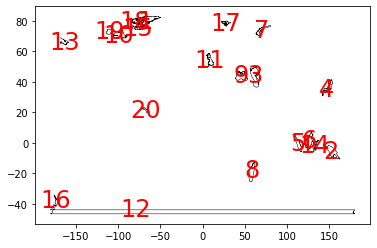

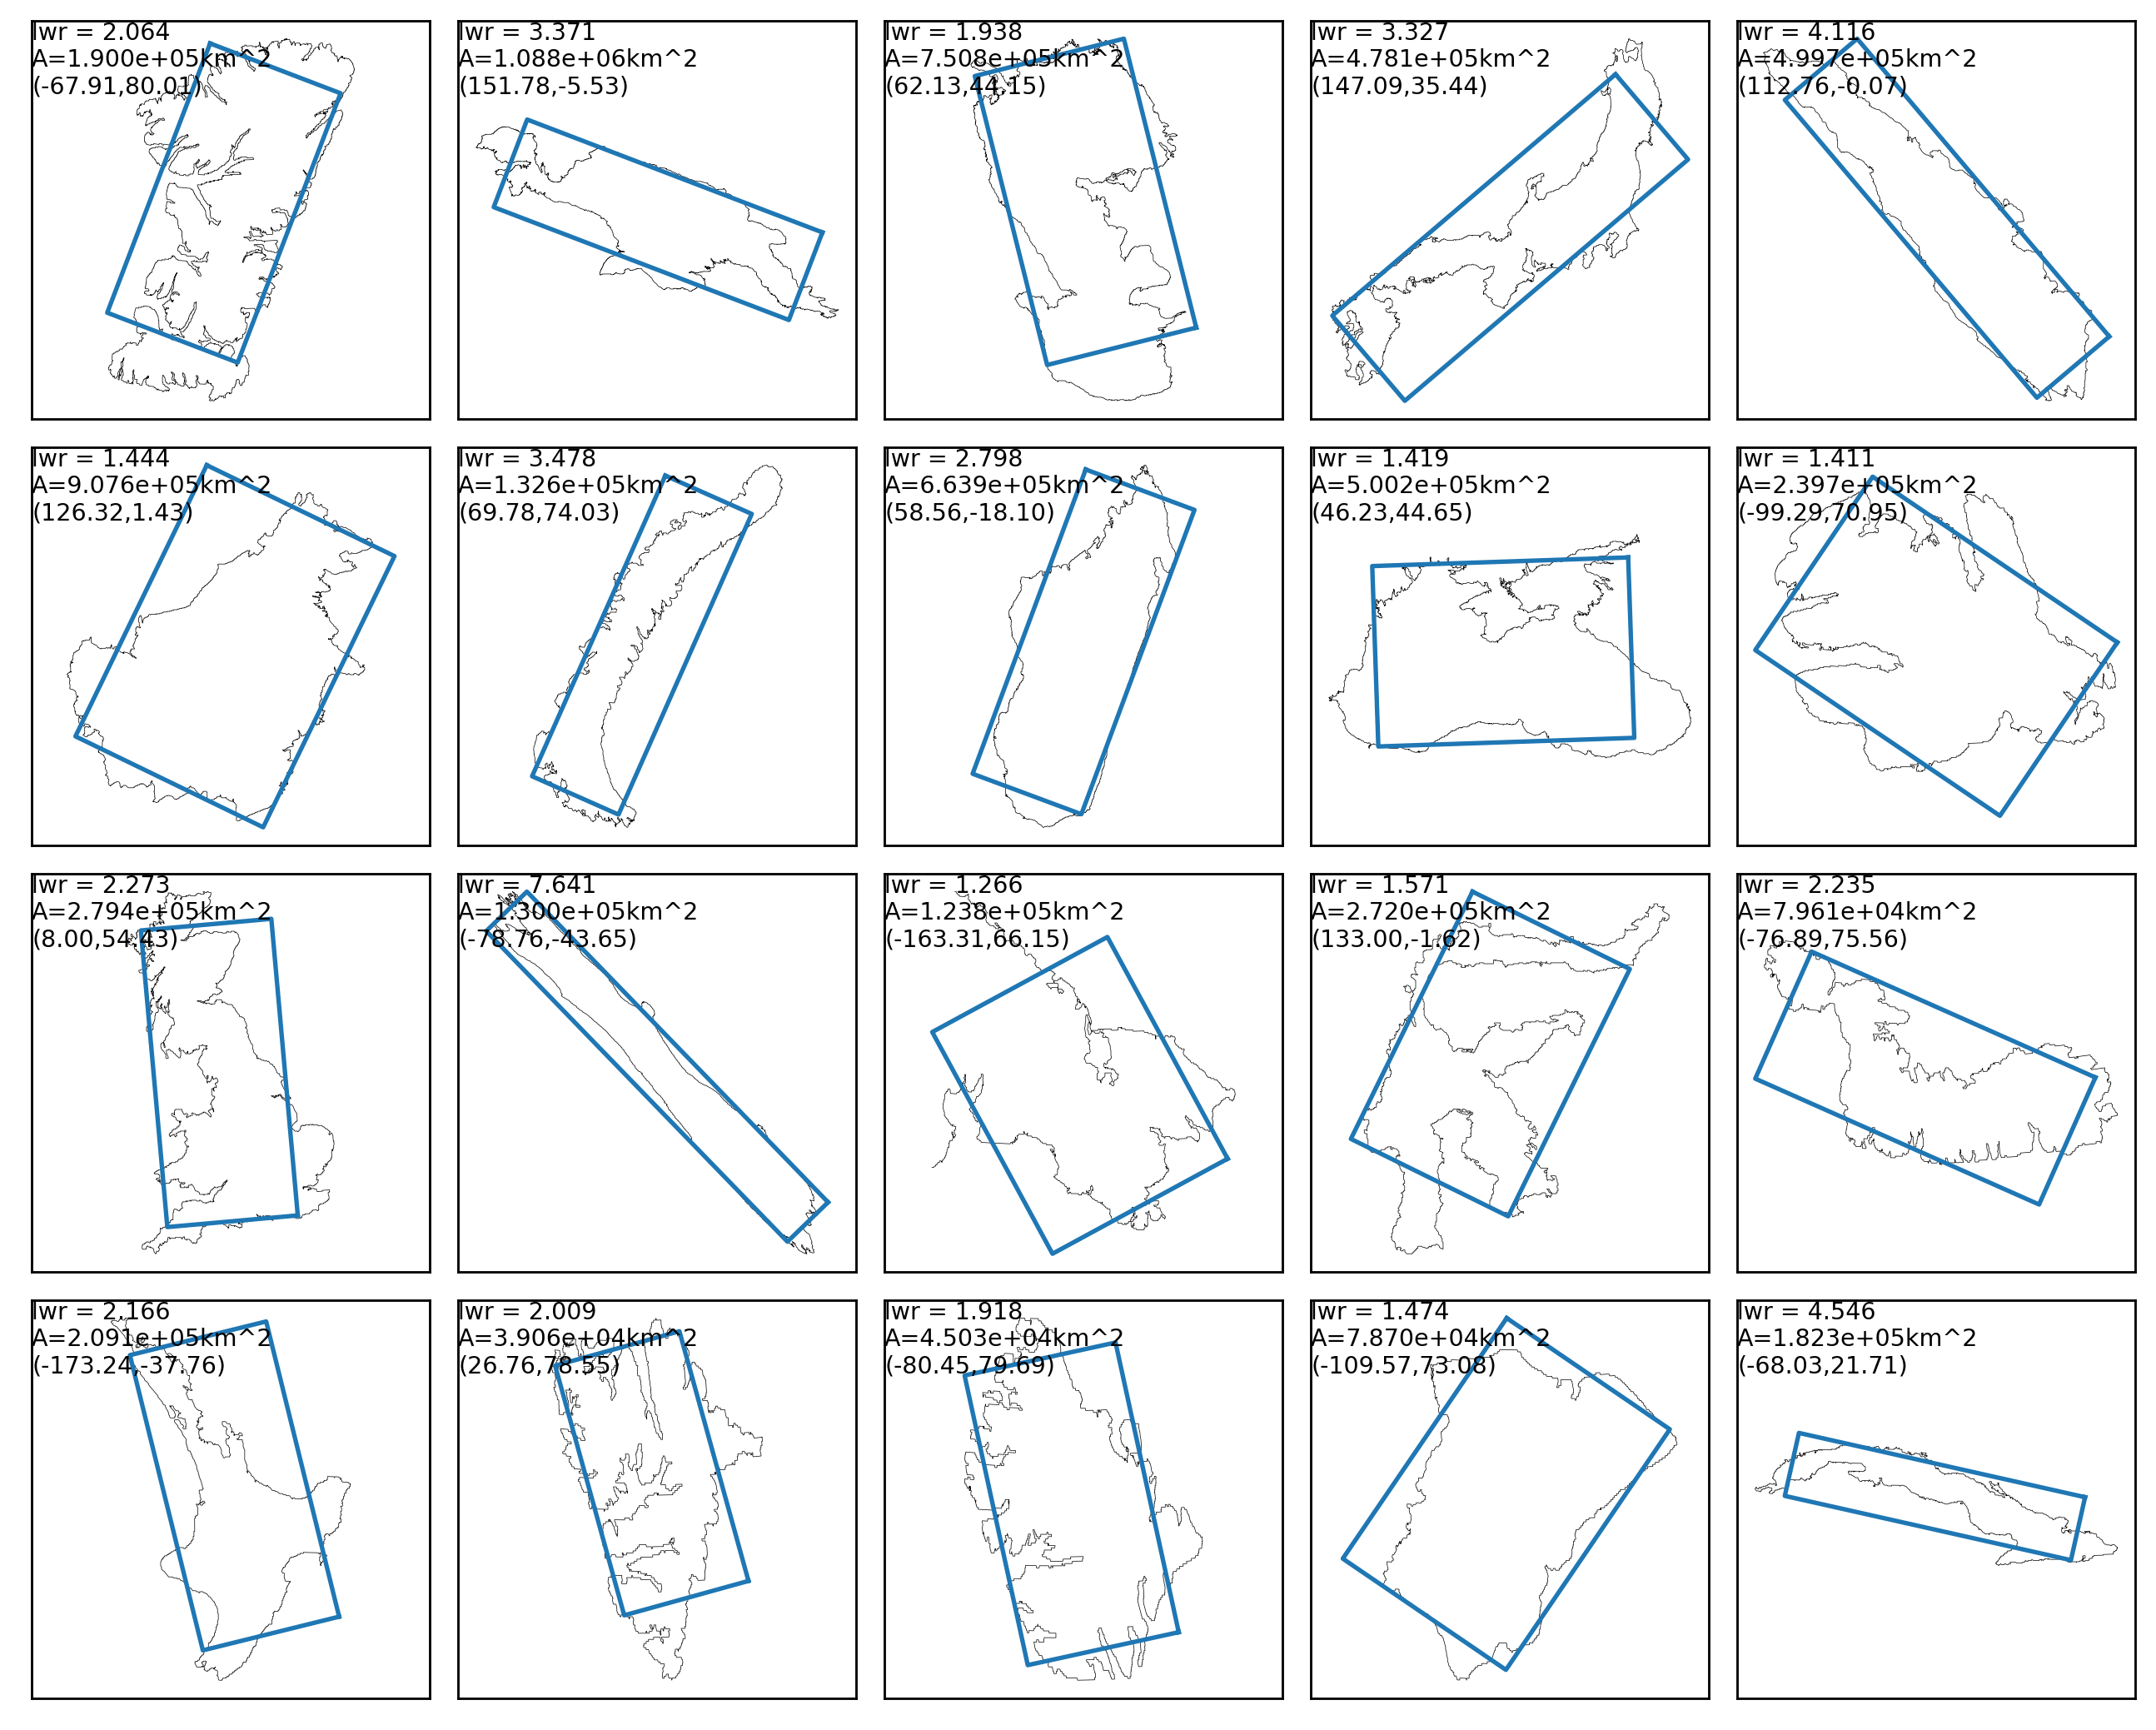

In [128]:
nx, ny = 5, 4

fig, world = plt.subplots(1, 1)

fig, axes = plt.subplots(ny, nx, figsize=(2*nx, 2*ny), dpi=256, constrained_layout=True)

n_ax = len(axes.ravel())

ic = 5

for iax, ax in enumerate(axes.ravel()):
    
    lwr, area = 0, 0
    
    while not lwr > 1:
        
        ic += 1
    
        contour = contours[ic]
        c_lon, c_lat = np.radians(lon[contour[:,0].astype(int)]), np.radians(lat[contour[:,1].astype(int)])

        dx, dy = to_xy(c_lon, c_lat, c_lon.mean(), c_lat.mean())

        z_contour = dx + 1j * dy    
        mara = np.pi/2 + get_MARA(z_contour)

        z_trans = z_contour * np.exp(1j * mara)
        dx_trans, dy_trans = np.real(z_trans), np.imag(z_trans)

        l0, l1 = np.percentile(dx_trans, q=[10, 90])
        w0, w1 = np.percentile(dy_trans, q=[10, 90])

        z_box = np.exp(-1j * mara) * np.array([l0+1j*w0,l0+1j*w1,l1+1j*w1,l1+1j*w0,l0+1j*w0])
        x_box, y_box = np.real(z_box), np.imag(z_box)
    
        lwr = (l1-l0) / (w1-w0)
        
        area = (l1-l0) * (w1-w0) * np.square(6.378e3)
        
    print(iax, ic, lwr, area); clear_output(wait=True)
    
    
    ax.plot(dx, dy, c='k', lw=2e-1)
    ax.plot(x_box, y_box)
    
    world.plot(lon[contour[:,0].astype(int)], lat[contour[:,1].astype(int)], color='k', lw=5e-1)
    world.text(lon[contour[:,0].astype(int)].mean(), lat[contour[:,1].astype(int)].mean(), s=iax+1, fontsize=24, c='r', ha='center', va='center')
    #np.real(z_trans).ptp(), np.imag(z_trans).ptp()
    
    xs = ax.get_xlim()
    ys = ax.get_ylim()

    x0, y0 = np.mean(xs), np.mean(ys)
    r = 0.5 * np.maximum(np.ptp(xs), np.ptp(ys))
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.text(x0-r,y0+r,f'lwr = {lwr:.03f}\nA={area:.03e}km^2\n({np.degrees(c_lon.mean()):.02f},{np.degrees(c_lat.mean()):.02f})', fontsize=8, ha='left', va='top')

    ax.set_xlim(x0-r,x0+r)
    ax.set_ylim(y0-r,y0+r)

In [ ]:
nx, ny = 5, 4

fig, axes = plt.subplots(ny, nx, figsize=(2*nx, 2*ny), dpi=256, constrained_layout=True)

n_ax = len(axes.ravel())

ic = -1

for iax, ax in enumerate(axes.ravel()):
    
    lwr, area = 0, 0
    
    while not lwr > 3:
        
        ic += 1
    
        contour = contours[ic]
        c_lon, c_lat = np.radians(lon[contour[:,0].astype(int)]), np.radians(lat[contour[:,1].astype(int)])

        dx, dy = to_xy(c_lon, c_lat, c_lon.mean(), c_lat.mean())

        z_contour = dx + 1j * dy    
        mara = np.pi/2 + get_MARA(z_contour)

        z_trans = z_contour * np.exp(1j * mara)
        dx_trans, dy_trans = np.real(z_trans), np.imag(z_trans)

        l0, l1 = np.percentile(dx_trans, q=[10, 90])
        w0, w1 = np.percentile(dy_trans, q=[10, 90])

        z_box = np.exp(-1j * mara) * np.array([l0+1j*w0,l0+1j*w1,l1+1j*w1,l1+1j*w0,l0+1j*w0])
        x_box, y_box = np.real(z_box), np.imag(z_box)
    
        lwr = (l1-l0) / (w1-w0)
        
        area = (l1-l0) * (w1-w0) * np.square(6.378e3)
        
    print(iax, ic, lwr, area); clear_output(wait=True)
    
    
    ax.plot(dx, dy, c='k', lw=2e-1)
    ax.plot(x_box, y_box)
    

    #np.real(z_trans).ptp(), np.imag(z_trans).ptp()
    
    xs = ax.get_xlim()
    ys = ax.get_ylim()

    x0, y0 = np.mean(xs), np.mean(ys)
    r = 0.5 * np.maximum(np.ptp(xs), np.ptp(ys))
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.text(x0-r,y0+r,f'lwr = {lwr:.03f}\nA={area:.03e}km^2\n({np.degrees(c_lon.mean()):.02f},{np.degrees(c_lat.mean()):.02f})', fontsize=8, ha='left', va='top')

    ax.set_xlim(x0-r,x0+r)
    ax.set_ylim(y0-r,y0+r)

array([[-3575, -3578, -3586, -3596, -3600, -3596, -3587, -3577, -3563,
        -3554, -3550, -3549, -3549, -3551, -3559, -3564],
       [-3567, -3559, -3565, -3576, -3583, -3583, -3580, -3573, -3562,
        -3554, -3551, -3551, -3551, -3556, -3567, -3573],
       [-3554, -3548, -3548, -3558, -3563, -3565, -3563, -3562, -3557,
        -3553, -3551, -3552, -3555, -3569, -3584, -3589],
       [-3556, -3551, -3543, -3549, -3551, -3554, -3556, -3555, -3555,
        -3554, -3554, -3557, -3560, -3578, -3595, -3600],
       [-3559, -3547, -3532, -3536, -3548, -3552, -3554, -3555, -3557,
        -3557, -3557, -3560, -3567, -3584, -3599, -3602],
       [-3565, -3546, -3531, -3537, -3550, -3553, -3554, -3557, -3560,
        -3562, -3563, -3566, -3572, -3587, -3599, -3600],
       [-3571, -3557, -3546, -3572, -3558, -3557, -3560, -3562, -3562,
        -3565, -3567, -3572, -3580, -3592, -3598, -3597],
       [-3568, -3558, -3553, -3555, -3560, -3572, -3573, -3570, -3568,
        -3572, -3578, -358

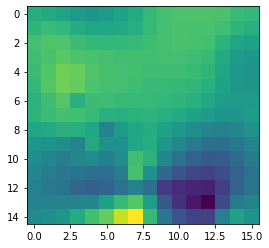

In [106]:
plt.imshow(MH[mi][:,mj])